# Spatial Cross-validation - Example

## Setup

Load required packages

In [11]:
import pandas as pd
import io
import requests
import numpy as np
import random
import libpysal
import pysal
import pysal.lib

Read data

In [12]:
#Read from URL (Doesnt work for private repos)
url="https://github.com/konstantinklemmer/spatial_utilities/raw/master/data/data.csv"
s=requests.get(url).content
data=pd.read_csv(io.StringIO(s.decode('utf-8')))

#Read from local file
#data=pd.read_csv("./data.csv")

This is a spatial dataset defined by two spatial dimensions, `latitude` and `longitude`.

In [13]:
data.head(5)

,id,y,z,latitude,longitude
0,1,-0.844504,1.370958,2.5,2.5
1,2,-0.832568,-0.564698,2.5,7.5
2,3,-0.793995,0.363128,2.5,12.5
3,4,-0.730340,0.632863,2.5,17.5
4,5,-0.641493,0.404268,2.5,22.5


## Spatial CV with Slicing

This method loops over our lat/lon groups, keeping each group as test data and the rest as train data. However, as we want to do spatial cross-validation, we remove neighbors of the test set. This can help to prevent model overfitting.

In [14]:
def spatial_cv_slicing(df,coords,slices=5,k=8,discrete=False,disc_neighbourhood="queen"):
    # ```
    # Spatial Cross-Validation using slicing
    #
    # Input:
    # df = pandas dataframe to be sliced .
    # coords = names of the spatial coordiante columns.
    # slices = no. of slices across each spatial dimension.
    # k = no. of nearest-neighbours to define the boundary size.
    # discrete = logical value if data is discrete spatial (e.g. regular point grid) or not.
    # disc_neigbourhood = any of ["king","queen","queen_2nd"]. Defines which neighbourhood 
    #                     structure to apply to define holdout area.
    #
    # Output:
    # (1) The sliced dataframe with columns for each slice named "fold_1" - "fold_n" (where n = slices *2).
    #     The value 1 indicates test set, 2 indicates training set and 0 indicates omitted observation
    # (2) Array of names of columns, ["fold_1",...,"fold_n"]
    #
    # Example: sliced_df = spatial_cv_slicing(df,["latitude","longitude"],slices=6,discrete=True,disc_neighbourhood="king")
    # ```
    
    l = [i+1 for i in range(slices)]
    df["temp_id"] = [i+1 for i in range(df.shape[0])]
    df["x_group"] = pd.cut(data[coords[0]],bins=slices,labels=l)
    df["y_group"] = pd.cut(data[coords[1]],bins=slices,labels=l)
    
    kd = pysal.lib.cg.kdtree.KDTree(np.array(df[coords]))
        
    if discrete is False:
        w = pysal.lib.weights.KNN(kd, k)
        
        for q in list(df)[-2::]: #Loop over the two slicing label columns 
            df["s_id"] = df[q] #Define which label column to use for slicing

            for j in np.unique(df["s_id"]): #Loop over the unique labels in the slicing column 

                df[q+str(j)] = 0

                test = df[df["s_id"]==j] #Define test data 
                df.loc[df["temp_id"].isin(np.array(test["temp_id"])),q+str(j)] = 1

                temp_id = [] #Create empty neighbourhood index

                for h in test.index: #Fill neighborhood index using first degree neighbors of test data
                    temp_id = np.unique(np.concatenate([temp_id,w.neighbors[h]]).ravel().astype(np.int32))

                train = df[df["s_id"]!=j] #Define train data 
                train = train.drop(temp_id,errors="ignore") #Exclude neighbors from index
                df.loc[df["temp_id"].isin(np.array(train["temp_id"])),q+str(j)] = 2
        
    else:
        dist = pysal.lib.cg.distance_matrix(np.array(df[coords]))
        u_dist = np.unique(dist)
        k_min_dist = np.sort(u_dist.flatten())[:k]
        
        if disc_neighbourhood in ["queen","queen_2nd"]:
            w = pysal.lib.weights.distance.DistanceBand(kd, threshold=k_min_dist[2],binary=True,p=2)
        else:
            w = pysal.lib.weights.distance.DistanceBand(kd, threshold=k_min_dist[1],binary=True,p=2)
        
        for q in list(df)[-2::]: #Loop over the two slicing label columns 
            df["s_id"] = df[q] #Define which label column to use for slicing
    
            for j in np.unique(df["s_id"]): #Loop over the unique labels in the slicing column 
        
                df[q+str(j)] = 0

                test = df[df["s_id"]==j] #Define test data 
                df.loc[df["temp_id"].isin(np.array(test["temp_id"])),q+str(j)] = 1

                temp_id = [] #Create empty neighbourhood index
                
                if disc_neighbourhood=="queen":
                    for h in test.index: #Fill neighborhood index using first degree neighbors of test data
                        temp_id = np.unique(np.concatenate([temp_id,w.neighbors[h]]).ravel().astype(np.int32))
                
                elif disc_neighbourhood=="queen_2nd":
                    for h in test.index: #Fill neighborhood index using first degree neighbors of test data
                        temp_id = np.unique(np.concatenate([temp_id,w.neighbors[h]]).ravel().astype(np.int32))
                    for u in temp_id: #Include second degree neighbors
                        temp_id = np.unique(np.concatenate([temp_id,w.neighbors[u]]).ravel().astype(np.int32))
                
                elif disc_neighbourhood=="king":
                    for h in test.index: #Fill neighborhood index using first degree neighbors of test data
                        temp_id = np.unique(np.concatenate([temp_id,w.neighbors[h]]).ravel().astype(np.int32))
                
                else:
                    print("Invalid neighbourhood definition for discrete data")

                train = df[df["s_id"]!=j] #Define train data 
                train = train.drop(temp_id,errors="ignore") #Exclude neighbors from index
                df.loc[data["id"].isin(np.array(train["id"])),q+str(j)] = 2
    
    #Drop helper columns
    df = df.drop(columns=["x_group","y_group","s_id","temp_id"])
    # Rename columns
    col_names = []
    for i in [i+1 for i in range(slices*2)]:
        col_names += ["fold_" + str(i)]
    df.rename(columns=dict(zip(df.filter(regex='_group').columns,col_names)), inplace=True)
    #Return dataframe
    return df, col_names    

Let's see how it works: Here, we remove 1st and 2nd degree neighbors (`disc_neighbourhood="queen_2nd"`), but the method can be adapted as needed. We create 10 folds (5 lon, 5 lat slicing) and save these in the columns `lat_group[1-5]` and `lon_group[1-5]`. For the values in each of these columns, `1` indicates testing data, `2` training data and `0`indicates data to be removed.

In [15]:
test_df, test_coln = spatial_cv_slicing(data,["longitude","latitude"],slices=5,discrete=True,disc_neighbourhood="queen_2nd")

Let's see how the dataframe looks:

In [25]:
test_df.head(5)

,id,y,z,latitude,longitude,fold_1,fold_2,fold_3,fold_4,fold_5,fold_6,fold_7,fold_8,fold_9,fold_10
0,1,-0.844504,1.370958,2.5,2.5,1,2,2,2,2,1,2,2,2,2
1,2,-0.832568,-0.564698,2.5,7.5,1,2,2,2,2,1,2,2,2,2
2,3,-0.793995,0.363128,2.5,12.5,1,0,2,2,2,1,2,2,2,2
3,4,-0.730340,0.632863,2.5,17.5,1,0,2,2,2,1,2,2,2,2
4,5,-0.641493,0.404268,2.5,22.5,0,1,2,2,2,1,2,2,2,2


Let's plot our results. How does `fold_7` look? 

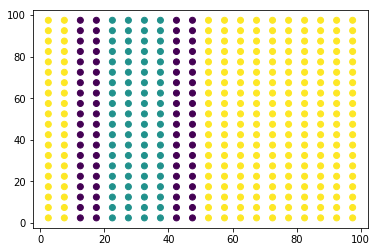

In [24]:
import matplotlib.pyplot as plt
#import matplotlib.cm as cm

x = test_df["longitude"]
y = test_df["latitude"]
c = test_df["fold_2"]

fig, ax = plt.subplots()
scatter = ax.scatter(x, y, c=c)
plt.show()